# Course Project
### DATA 512 - Human-Centered Data Science
#### Aamir Darukhanawalla

### Common Analysis (Part 1)

### Analysis Question:
##### How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 1, 2021?

#### Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.stats import pearsonr

In [2]:
# Set assigned county as Hudson
COUNTY = 'Hudson'

#### Read the data for US Confirmed Cases

In [3]:
df_us_cases = pd.read_csv('Data/RAW_us_confirmed_cases.csv')

In [4]:
df_us_cases.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,...,18480,18480,18480,18480,18480,18480,18511,18511,18511,18511
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,...,65895,65895,65895,65895,65895,65895,65973,65973,65973,65973
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,...,6926,6926,6926,6926,6926,6926,6930,6930,6930,6930
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,...,7560,7560,7560,7560,7560,7560,7575,7575,7575,7575
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,...,17286,17286,17286,17286,17286,17286,17320,17320,17320,17320


In [5]:
# Confirmed cases data for Hudson County
df_us_cases[df_us_cases['Admin2'] == COUNTY]

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22
1852,New Jersey,Hudson,84034017,US,USA,840,34017.0,US,40.737662,-74.075157,...,217629,217720,217804,217815,217940,218066,218216,218390,218687,218687


In [6]:
# Get the time series for Hudson county confirmed cases from 2/1/20 to 10/1/20
ts_hudson_cases = df_us_cases[
                      df_us_cases['Admin2'] == COUNTY
                  ].iloc[
                      0, df_us_cases.columns.get_loc('2/1/20') : df_us_cases.columns.get_loc('10/1/21') + 1
                  ].rename('{} Cases'.format(COUNTY))

In [7]:
ts_hudson_cases.tail()

9/27/21    95450
9/28/21    95515
9/29/21    95589
9/30/21    95687
10/1/21    95777
Name: Hudson Cases, dtype: object

Text(0, 0.5, 'Confirmed cases')

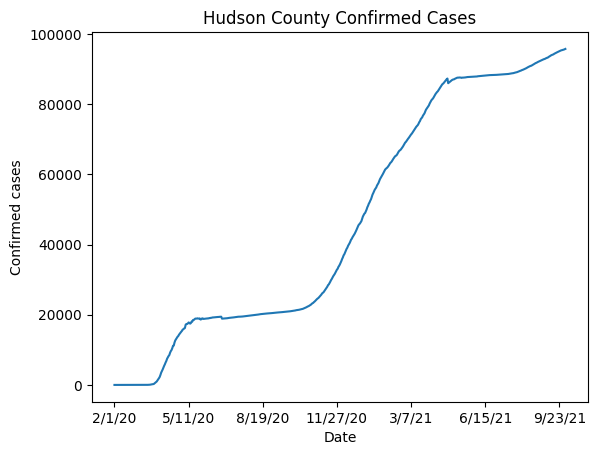

In [8]:
ts_hudson_cases.plot()
plt.title('Hudson County Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Confirmed cases')

#### Read data for the mask survey

In [9]:
df_mask_use = pd.read_csv('Data/mask-use-by-county.csv')

In [10]:
# Get the survey results for Hudson county
df_mask_use[df_mask_use['COUNTYFP'] == int(df_us_cases.loc[df_us_cases['Admin2'] == COUNTY, 'FIPS'])]

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1782,34017,0.022,0.019,0.077,0.211,0.67


#### Read the mask mandate data

In [11]:
df_mask_mandate = pd.read_csv('Data/mask-mandate.csv')

In [12]:
# Get the mask mandate data for Hudson county
ts_mask_mandate = df_mask_mandate[df_mask_mandate['County_Name'] == '{} County'.format(COUNTY)].set_index('date')['Face_Masks_Required_in_Public']

In [13]:
ts_mask_mandate.head()

date
4/10/2020    Yes
4/11/2020    Yes
4/12/2020    Yes
4/13/2020    Yes
4/14/2020    Yes
Name: Face_Masks_Required_in_Public, dtype: object

In [14]:
ts_mask_mandate.tail()

date
8/11/2021    No
8/12/2021    No
8/13/2021    No
8/14/2021    No
8/15/2021    No
Name: Face_Masks_Required_in_Public, dtype: object

Text(0, 0.5, 'Had mask mandate')

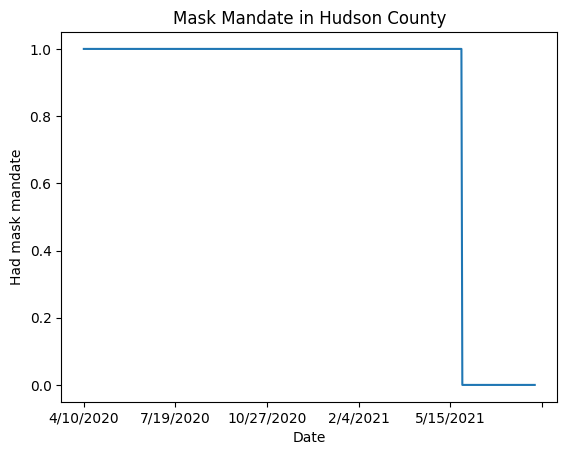

In [15]:
ts_mask_mandate.map({'Yes': 1, 'No': 0}).plot()
plt.title('Mask Mandate in Hudson County')
plt.xlabel('Date')
plt.ylabel('Had mask mandate')

In [16]:
(ts_mask_mandate[:ts_mask_mandate.index.get_loc('5/28/2021')] == 'Yes').all()

True

In [17]:
(ts_mask_mandate[ts_mask_mandate.index.get_loc('5/28/2021'):] == 'No').all()

True

We see that the all dates before 5/28/2021 have a mask mandate in public and all dates on or after 5/28/2021 have no mask mandate.
Hence, the mask mandate was changed only once in Hudson county. On 5/28/2021 the mask mandate in public was changed from 'Yes' to 'No'.

##### Visualizing the confirmed cases with respect to the day the mask mandate was removed in Hudson county.

Text(0, 0.5, 'Confirmed cases')

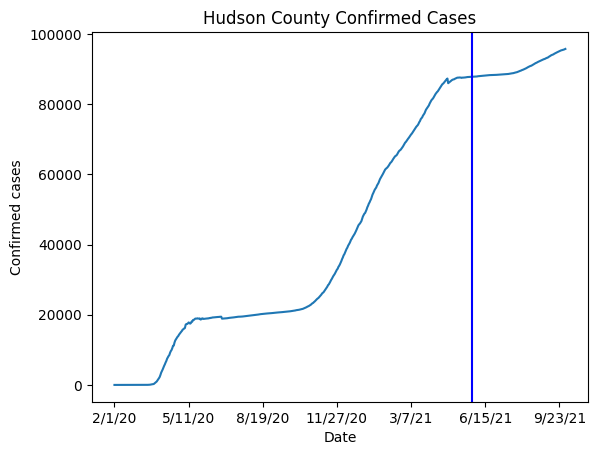

In [18]:
ts_hudson_cases.plot()
plt.axvline(x = ts_hudson_cases.index.get_loc('5/28/21'), color = 'b')
plt.title('Hudson County Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Confirmed cases')

We take the derivative of the total confirmed cases to get the daily increase in cases.
However, we do notice a number of dates having a negative number of cases. These errors are most likely due to adjustments made to the numbers to offset previous errors. Since such days are very few we can just cut off the daily cases values at zero.

Text(0, 0.5, 'Daily cases')

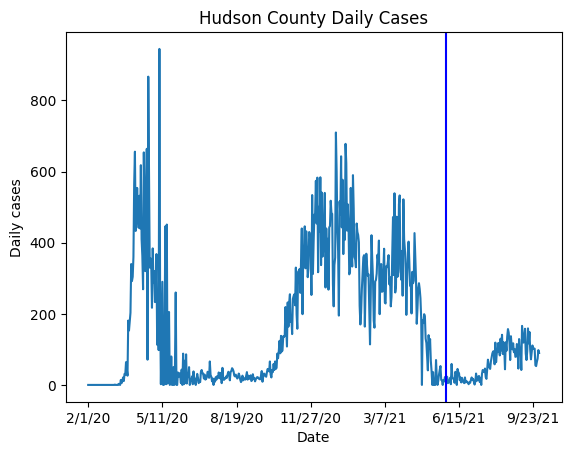

In [19]:
ts_hudson_cases.diff().fillna(ts_hudson_cases).clip(0).plot()
plt.axvline(x = ts_hudson_cases.index.get_loc('5/28/21'), color = 'b')
plt.title('Hudson County Daily Cases')
plt.xlabel('Date')
plt.ylabel('Daily cases')

We are able to see long term trends from the above graph. However, we see a lot of short-term variance. This can be due to biases in the reporting days. We shall be able to see the trends better after taking a moving average over the week, i.e. 7-day moving average.

Text(0, 0.5, 'Daily cases')

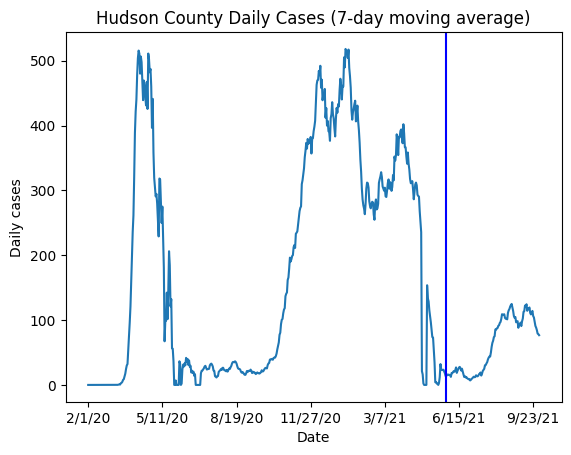

In [20]:
ts_hudson_cases.diff().rolling(7).mean().fillna(ts_hudson_cases).clip(0).plot()
plt.axvline(x = ts_hudson_cases.index.get_loc('5/28/21'), color = 'b')
plt.title('Hudson County Daily Cases (7-day moving average)')
plt.xlabel('Date')
plt.ylabel('Daily cases')

<AxesSubplot: >

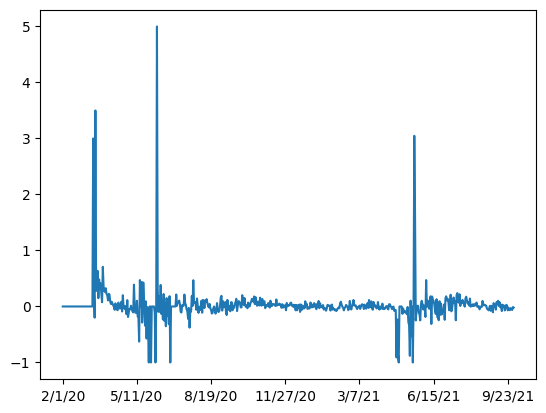

In [21]:
# Plotting the growth rate of new daily cases
ts_hudson_cases.diff().rolling(7).mean().fillna(ts_hudson_cases).clip(0).pct_change().fillna(0).replace(np.inf, 0).clip(-5, 5).plot()

We plot the growth rate for increase in daily covid cases. However, I do not find the graph to valuable to relate to the mask mandate.

### The Final Visualization (Part 1)

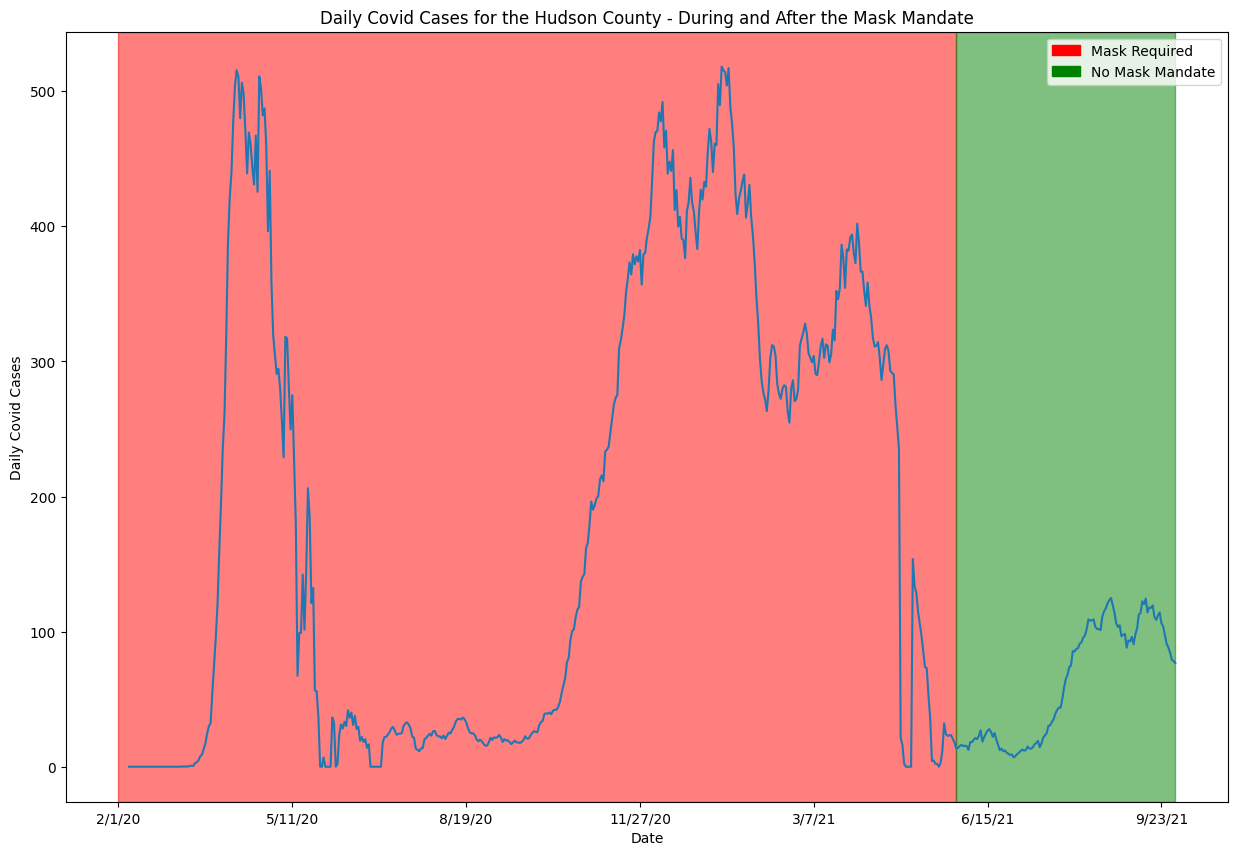

In [22]:
ts_hudson_cases.diff().fillna(ts_hudson_cases).rolling(7).mean().clip(0).plot(figsize=(15, 10))
plt.axvspan(ts_hudson_cases.index.get_loc('2/1/20'), ts_hudson_cases.index.get_loc('5/28/21'), color='red', alpha=0.5)
plt.axvspan(ts_hudson_cases.index.get_loc('5/28/21'), ts_hudson_cases.index.get_loc('10/1/21'), color='green', alpha=0.5)
plt.title('Daily Covid Cases for the Hudson County - During and After the Mask Mandate')
plt.xlabel('Date')
plt.ylabel('Daily Covid Cases')
plt.legend(handles=[mpatches.Patch(color='red', label='Mask Required'), mpatches.Patch(color='green', label='No Mask Mandate')])
plt.savefig('Hudson county daily cases.png')
plt.show()

### Project Analysis (Parts 2-4)

### Research Questions:

##### Q1. How did the increase in COVID-19 **cases** in Hudson County affect its unemployment rate?
##### Q2. How did the increase in COVID-19 **deaths** in Hudson County affect its unemployment rate?
##### Q3. Does the employment rate in Hudson County depend more on the number of COVID cases or the number of deaths due to COVID-19?

#### Read the data for Hudson County Unemployment Rate

In [23]:
df_unemployment = pd.read_csv('Data/unemployment-rate-hudson-nj.csv')

In [24]:
# Rename encoding column name to a human understandable term
df_unemployment.rename(columns={'NJHUDS7URN': 'Unemployment'}, inplace=True)

In [25]:
df_unemployment.head()

,DATE,Unemployment
0,1990-01-01,7.7
1,1990-02-01,7.6
2,1990-03-01,7.3
3,1990-04-01,7.1
4,1990-05-01,7.3


In [26]:
# Get the time series for Hudson county confirmed cases from 2/1/20 to 10/1/20
ts_unemployment = df_unemployment.set_index('DATE')
ts_unemployment.index = pd.to_datetime(ts_unemployment.index)
ts_unemployment = ts_unemployment['2020-02-01':'2021-10-01']

In [27]:
ts_unemployment.head()

,Unemployment
DATE,
2020-02-01,3.4
2020-03-01,3.8
2020-04-01,15.4
2020-05-01,17.0
2020-06-01,15.9


In [28]:
# Get the time series for hudson cases daily
ts_hudson_cases_daily = ts_hudson_cases.diff().fillna(ts_hudson_cases).clip(0)
ts_hudson_cases_daily.index = pd.to_datetime(ts_hudson_cases_daily.index)
ts_hudson_cases_daily.tail()

2021-09-27    53
2021-09-28    65
2021-09-29    74
2021-09-30    98
2021-10-01    90
Name: Hudson Cases, dtype: int64

In [29]:
# Get the time series for hudson cases monthly, by aggregating the daily cases
ts_hudson_cases_monthly = ts_hudson_cases_daily.resample('MS').sum()
ts_hudson_cases_monthly.tail()

2021-06-01     499
2021-07-01    1046
2021-08-01    3205
2021-09-01    3052
2021-10-01      90
Freq: MS, Name: Hudson Cases, dtype: int64

In [30]:
# Create a time series dataframe for COVID cases and Unemployment Rate
ts_cases_unemployment = ts_hudson_cases_monthly.to_frame().join(ts_unemployment)
ts_cases_unemployment.head()

,Hudson Cases,Unemployment
2020-02-01,0,3.4
2020-03-01,1606,3.8
2020-04-01,13310,15.4
2020-05-01,4783,17.0
2020-06-01,717,15.9


Text(0, 0.5, 'Unemployment Rate')

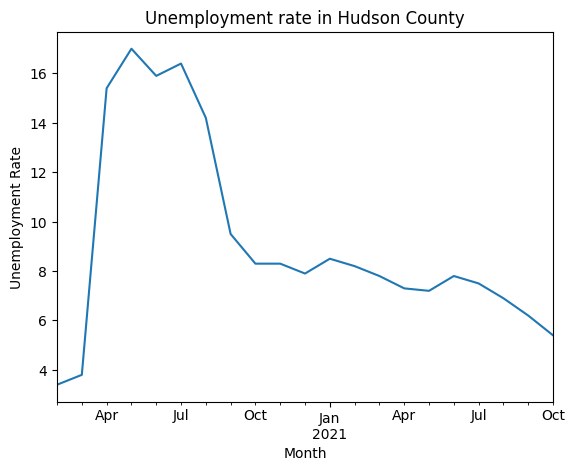

In [31]:
# Visualizing the unemployment rate for the duration of the pandemic
ts_cases_unemployment['Unemployment'].plot()
plt.title('Unemployment rate in Hudson County')
plt.xlabel('Month')
plt.ylabel('Unemployment Rate')

Text(0.5, 1.0, 'Comparing COVID cases with the Unemployment rate')

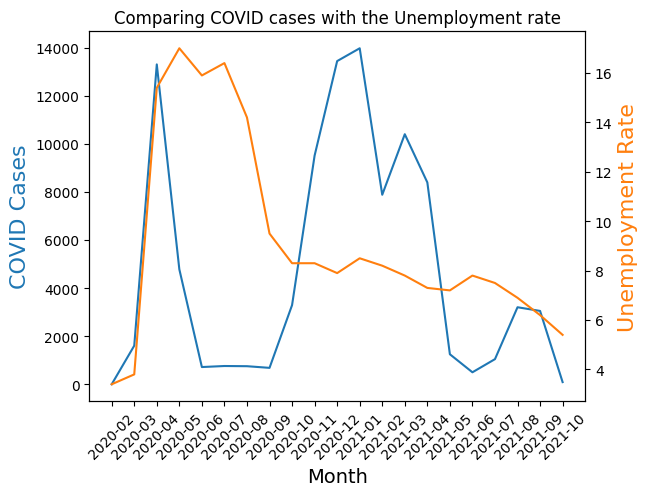

In [32]:
fig,ax = plt.subplots()

color1 = 'tab:blue'
color2 = 'tab:orange'

ax.plot(ts_cases_unemployment.index.strftime('%Y-%m'), ts_cases_unemployment['Hudson Cases'], color=color1)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('COVID Cases', fontsize=16, color=color1)
plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(ts_cases_unemployment.index.strftime('%Y-%m'), ts_cases_unemployment['Unemployment'], color=color2)
ax2.set_ylabel('Unemployment Rate', fontsize=16, color=color2)
plt.title('Comparing COVID cases with the Unemployment rate')

We notice some correlation during the beginning of the first wave. However, overall we do not see any significant correlation.

#### Pearson Correlation Analysis

##### Finding the correlation between COVID cases and Unemployment rate

In [43]:
r_p = pearsonr(ts_cases_unemployment['Hudson Cases'], ts_cases_unemployment['Unemployment'])
r, p = r_p
ci = r_p.confidence_interval()
print('Pearson Correlation = ', r)
print('P-value = ', p)
print(ci)

Pearson Correlation =  0.069380691723181
P-value =  0.7650668689220333
ConfidenceInterval(low=-0.373492458568409, high=0.48649654580461427)


Text(0.5, 0.98, 'Covid confirmed cases and unemployment rate')

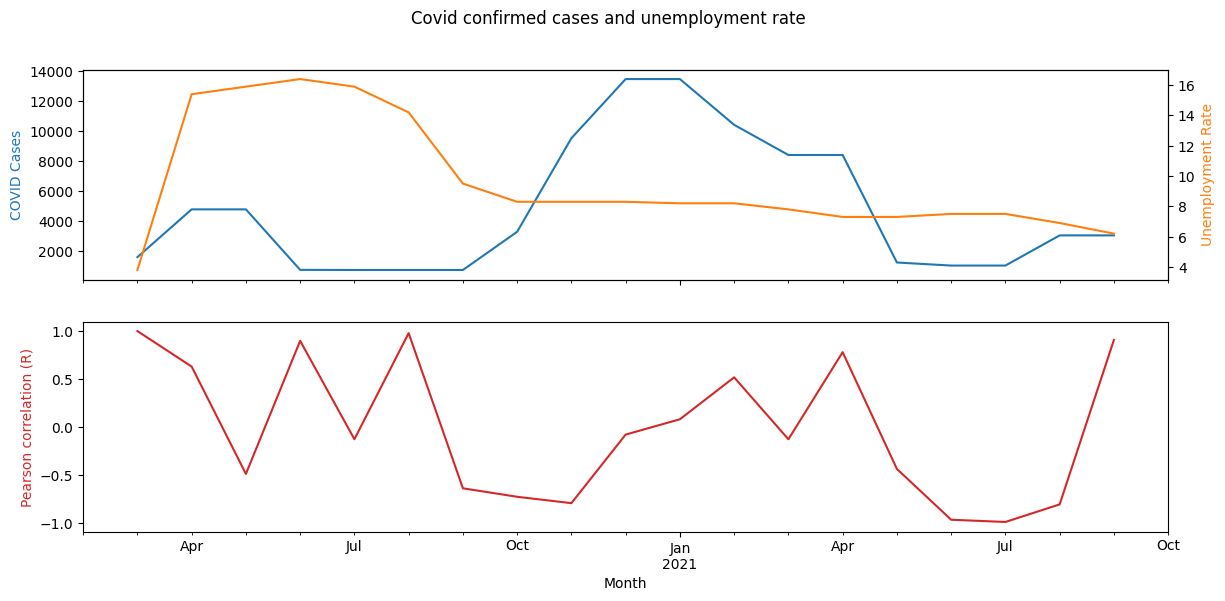

In [34]:
# Visualize the frame-wise Pearson correlation for COVID cases and unemployment rate
r_window_size = 3
rolling_r = ts_cases_unemployment['Hudson Cases'].rolling(window=r_window_size, center=True).corr(ts_cases_unemployment['Unemployment'])
f, ax =plt.subplots(2, 1, figsize=(14,6), sharex=True)
ax2 = ax[0].twinx()
ts_cases_unemployment['Hudson Cases'].rolling(window=r_window_size, center=True).median().plot(ax=ax[0], color='tab:blue')
ts_cases_unemployment['Unemployment'].rolling(window=r_window_size, center=True).median().plot(ax=ax2, color='tab:orange')
ax2.set_ylabel('Unemployment Rate', color='tab:orange')
ax[0].set(xlabel='Month', ylabel='COVID Cases')
ax[0].set_ylabel('COVID Cases', color='tab:blue')
rolling_r.plot(ax=ax[1], color='tab:red')
ax[1].set(xlabel='Month', ylabel='Pearson r')
ax[1].set_ylabel('Pearson correlation (R)', color='tab:red')
plt.suptitle("Covid confirmed cases and unemployment rate")

As expected, we notice some correlation during the beginning of the first wave. However, overall we do not see any significant correlation.

#### Read the data for US Deaths

In [35]:
df_us_deaths = pd.read_csv('Data/RAW_us_deaths.csv')

In [36]:
# Deaths data for Hudson County
df_us_deaths[df_us_deaths['Admin2'] == COUNTY]

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,11/24/22,11/25/22,11/26/22,11/27/22,11/28/22,11/29/22,11/30/22,12/1/22,12/2/22,12/3/22
1852,New Jersey,Hudson,84034017,US,USA,840,34017.0,US,40.737662,-74.075157,...,2806,2806,2806,2806,2806,2806,2807,2808,2810,2810


In [37]:
# Get the time series for Hudson county deaths from 2/1/20 to 10/1/20
ts_hudson_deaths = df_us_deaths[
                      df_us_deaths['Admin2'] == COUNTY
                  ].iloc[
                      0, df_us_deaths.columns.get_loc('2/1/20') : df_us_deaths.columns.get_loc('10/1/21') + 1
                  ].rename('{} Deaths'.format(COUNTY))

In [38]:
ts_hudson_deaths.tail()

9/27/21    2363
9/28/21    2364
9/29/21    2366
9/30/21    2367
10/1/21    2369
Name: Hudson Deaths, dtype: object

Text(0, 0.5, 'Deaths')

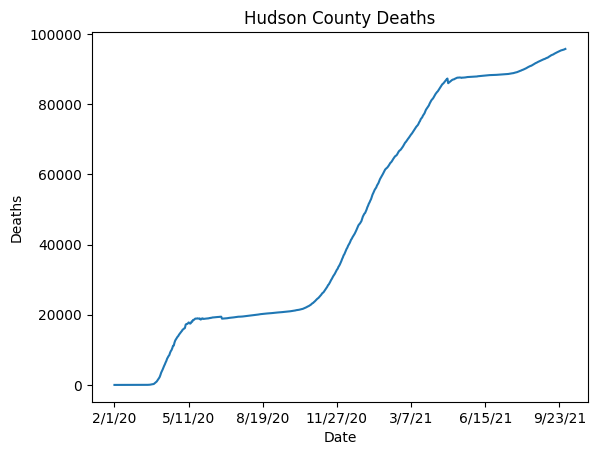

In [39]:
ts_hudson_cases.plot()
plt.title('Hudson County Deaths')
plt.xlabel('Date')
plt.ylabel('Deaths')

In [40]:
# Get the time series for hudson deaths daily
ts_hudson_deaths_daily = ts_hudson_deaths.diff().fillna(ts_hudson_deaths).clip(0)
ts_hudson_deaths_daily.index = pd.to_datetime(ts_hudson_deaths_daily.index)
ts_hudson_deaths_daily.tail()

2021-09-27    0
2021-09-28    1
2021-09-29    2
2021-09-30    1
2021-10-01    2
Name: Hudson Deaths, dtype: int64

In [41]:
# Get the time series for hudson deaths monthly, by aggregating the daily deaths
ts_hudson_deaths_monthly = ts_hudson_deaths_daily.resample('MS').sum().drop('2021-10-01')
ts_hudson_deaths_monthly.tail()

2021-05-01    68
2021-06-01    16
2021-07-01    14
2021-08-01    31
2021-09-01    23
Freq: MS, Name: Hudson Deaths, dtype: int64

In [42]:
# Create a time series dataframe for COVID deaths and Unemployment Rate
ts_deaths_unemployment = ts_hudson_deaths_monthly.to_frame().join(ts_unemployment)
ts_deaths_unemployment.head()

,Hudson Deaths,Unemployment
2020-02-01,0,3.4
2020-03-01,7,3.8
2020-04-01,841,15.4
2020-05-01,387,17.0
2020-06-01,268,15.9


##### Finding the correlation between COVID deaths and Unemployment rate

In [44]:
r_p = pearsonr(ts_deaths_unemployment['Hudson Deaths'], ts_deaths_unemployment['Unemployment'])
r, p = r_p
ci = r_p.confidence_interval()
print('Pearson Correlation = ', r)
print('P-value = ', p)
print(ci)

Pearson Correlation =  0.5901300165453667
P-value =  0.0061616943614491585
ConfidenceInterval(low=0.19978100403594903, high=0.8188201716160485)


Text(0.5, 0.98, 'Covid deaths and unemployment rate')

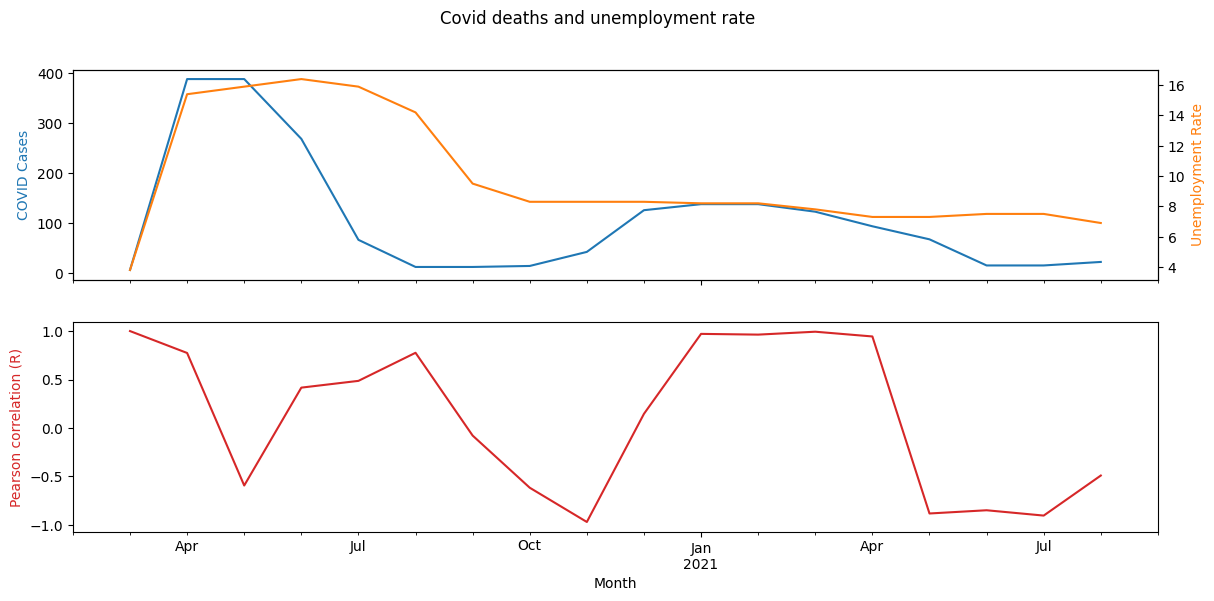

In [45]:
# Visualize the frame-wise Pearson correlation for COVID cases and unemployment rate
r_window_size = 3
rolling_r = ts_deaths_unemployment['Hudson Deaths'].rolling(window=r_window_size, center=True).corr(ts_deaths_unemployment['Unemployment'])
f, ax =plt.subplots(2, 1, figsize=(14,6), sharex=True)
ax2 = ax[0].twinx()
ts_deaths_unemployment['Hudson Deaths'].rolling(window=r_window_size, center=True).median().plot(ax=ax[0], color='tab:blue')
ts_deaths_unemployment['Unemployment'].rolling(window=r_window_size, center=True).median().plot(ax=ax2, color='tab:orange')
ax2.set_ylabel('Unemployment Rate', color='tab:orange')
ax[0].set(xlabel='Month', ylabel='COVID Deaths')
ax[0].set_ylabel('COVID Cases', color='tab:blue')
rolling_r.plot(ax=ax[1], color='tab:red')
ax[1].set(xlabel='Month', ylabel='Pearson r')
ax[1].set_ylabel('Pearson correlation (R)', color='tab:red')
plt.suptitle("Covid deaths and unemployment rate")

We notice a much stronger correlation between the unemployment rate and the COVID deaths as compared to the COVID cases.

#### Conclusion:

COVID **Confirmed Cases** vs Unemployment Rate:
  - R = 0.024714571151235428

COVID **Deaths** vs Unemployment Rate:
 - R = 0.5901300165453667

Clearly, the unemployment rate is more closely corelated to the COVID deaths, rather than the COVID Cases.
